In [1]:
# Packages installation 
!pip install allennlp transformers==4.11.2 datasets tensorflow pandas allennlp_models tensorflow_addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Librairies import
import pandas as pd
from datasets import load_dataset
from transformers import BertModel, BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np
import spacy
from allennlp.predictors.predictor import Predictor
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch.nn as nn
import torch
import itertools

In [3]:
# Import du data_utils où sont contenues les fonctions utilisées dans ce notebook
%run -i data_utils.py

In [4]:
# Checking GPU device
tf.test.gpu_device_name()


'/device:GPU:0'

## 1) Exploratory Data Analysis

In [5]:
# Downloading of SNLI dataset
dataset = load_dataset("snli")

# SNLI dataset overview
print(dataset)

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})


In [6]:
#  Create Dataframes out of  SNLI dataset samples 
df_train, df_test, df_validation = create_dataframes(dataset)

# Train sample representation 
df_train.head()

,premise,hypothesis,label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,1
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",2
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0
3,Children smiling and waving at camera,They are smiling at their parents,1
4,Children smiling and waving at camera,There are children present,0


<Axes: >

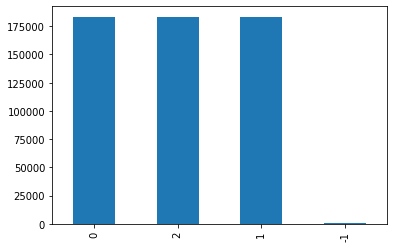

In [7]:
# Plot of the proportion of each label on the train sample
df_train["label"].value_counts().plot(kind='bar')

In [8]:
# Dropping observations where label is -1 because it represents missing labels 
df_train = drop_missing_labels(df_train)
df_test = drop_missing_labels(df_test)
df_validation = drop_missing_labels(df_validation)

In [9]:
# TESTING THE MODEL ON 15 ROWS
df_train = df_train.iloc[:15, :]
df_test = df_test.iloc[:15, :]
df_validation = df_validation.iloc[:15, :]

## 1.1 ) Data Preparation 

A - Creating lists that will contains premises and hypothesis of each samples

In [10]:
train_premises, train_hypotheses, train_labels = prepare_data(df_train)
test_premises, test_hypotheses, test_labels = prepare_data(df_test)
validation_premises, validation_hypotheses, validation_labels = prepare_data(df_validation)

## 2) Model Architecture Definition : 
- We are using a **pre-trained BERT model on un-annotated data** in order to get their tokens
- We are using a **Semantic Role Labeller in order to extract the semantic roles of each words in the inputs sentences** so that our model will better evaluate the relationship between premises and hypothesis based on the sentences semantic formulations.
- We have c**oncatened the outputs of pre-trained BERT model and our Semantic Role Labeller to feed it to a Dense Layer with 3 units and a Softmax activation function in order to perform Natural Language Inference (NLI) task** which is to predict whether a pair of sentences entails, contradicts or are neutral to each others.

### 2.1 ) BERT Implementation 

In [11]:
# Loading pre-trained BERT and its tokenizer
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
bert_model = BertModel.from_pretrained(MODEL_NAME)

# Tokenization of the inputs sequences 
inputs = tokenizer(train_premises,train_hypotheses, padding=True, truncation=True, return_tensors='tf')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 2.2) Semantic Role Labelling Implementation 

In [12]:
# Semantic Role Labelling (SRL) implementation in order to tag sentences and get the words roles 

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Define a maximum chunk size 
max_chunk_size = 100000

# Load the SRL predictor
predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/bert-base-srl-2020.11.19.tar.gz")

# Concatenate the input sentences
input_sentences = concatenate_sentences(train_premises, train_hypotheses)

# Define a list to store the SRL labels
srl_labels = []

# Process each input sentence separately
for sentence in input_sentences:
    # Split the sentence into chunks of maximum size
    chunks = split_chunks(sentence, max_chunk_size)

    # Process each chunk separately using spaCy
    doc = process_chunks(chunks)

    # Extract the verb-only SRL labels using AllenNLP
    srl_labels_chunk = extract_srl_labels(doc)
    srl_labels.append(srl_labels_chunk)



/usr/local/lib/python3.9/dist-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenc

In [13]:
# Padding the inputs sequences 
max_seq_length = 512
padded_inputs = {
    'input_ids': pad_sequences(inputs['input_ids'], maxlen=max_seq_length, padding='post'),
    'token_type_ids': pad_sequences(inputs['token_type_ids'], maxlen=max_seq_length, padding='post'),
    'attention_mask': pad_sequences(inputs['attention_mask'], maxlen=max_seq_length, padding='post'),
}


In [14]:
# Reducing variable sizes in order to reduce memory
tf.keras.backend.set_floatx('float16')

# Transforming BERT Inputs into tensor as required by the model 
input_ids = torch.tensor(padded_inputs['input_ids'], dtype=torch.int64)
token_type_ids = torch.tensor(padded_inputs['token_type_ids'], dtype=torch.int64)
attention_mask = torch.tensor(padded_inputs['attention_mask'], dtype=torch.int64)

# BERT Model Running
outputs = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)

# BERT model outputs recuperation 
last_hidden_state = outputs[0]


In [15]:
# List of each sentences tags recuperation 
srl_labels_list_tags = get_srl_labels_list_tags(srl_labels)

# Convert the list of tags to a tensor of strings
srl_labels_tensor = tf.ragged.constant(srl_labels_list_tags)


In [16]:
# Get a list of unique SRL labels in the dataset
unique_labels = set(label for sublist in srl_labels_list_tags for label in sublist)

# Create a label_map dictionary that maps each unique label to an integer
label_map = {}
for i, label in enumerate(sorted(unique_labels)):
    label_map[label] = i


In [17]:
#  Transforming the last_hidden_state BERT output into array
last_hidden_state_array = last_hidden_state.detach().numpy()

# Map the SRL labels to integer indices
srl_labels_indexed = [[label_map[label] for label in sublist] for sublist in srl_labels_list_tags]

# Pad the SRL labels sequences
max_srl_length = max(len(sublist) for sublist in srl_labels_indexed)
srl_labels_padded = pad_sequences(srl_labels_indexed, padding='post', value=label_map['O'])

# One-hot encode the SRL labels
num_srl_labels = len(label_map)
srl_labels_onehot = tf.keras.utils.to_categorical(srl_labels_padded, num_classes=num_srl_labels)
srl_labels_onehot_torch = torch.from_numpy(srl_labels_onehot)


# Define the pooling layer : we use the AdaptiveMaxPool1d layer to perform a global max pooling over the time dimension (the second dimension) of each input and semantic label sequence, and reduce them to a 1D tensor. Then, we concatenate these 1D tensors along the feature dimension (the last dimension), and pass the resulting concatenated representation through a linear (dense) layer to obtain the logits.
pooling_layer = nn.AdaptiveMaxPool1d(1)

# Apply the pooling layer to the last hidden states and the semantic labels
last_hidden_state_pooled = pooling_layer(last_hidden_state.permute(0, 2, 1)).squeeze(-1)
srl_labels_pooled = pooling_layer(srl_labels_onehot_torch.permute(0, 2, 1)).squeeze(-1)

# Concatenate the pooled representations
concatenated_representation = torch.cat((last_hidden_state_pooled, srl_labels_pooled), dim=-1)


## 3) Modelisation 

# A - Train Sample

## 3.1 ) Model performance without hyperparameters : 


In [18]:
# Converting the PyTorch tensor to a TensorFlow tensor 
concatenated_representation_np = concatenated_representation.detach().numpy()
concatenated_representation_tf = tf.convert_to_tensor(concatenated_representation_np)

# Construction of the model 
inputs = tf.keras.Input(shape=concatenated_representation_tf.shape[1:])
dense_layer = tf.keras.layers.Dense(3, activation='softmax')(inputs)
model_1 = tf.keras.Model(inputs=inputs, outputs=dense_layer)


# Compile the model
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

# Fit the model
model_1.fit(concatenated_representation_tf, df_train['label'], epochs=10, batch_size=32)


# Predictions

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 786)]             0         
                                                                 
 dense (Dense)               (None, 3)                 2361      
                                                                 
Total params: 2,361
Trainable params: 2,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.2285 - accuracy: 0.3999
Epoch 2/10
1/1 [==============================] - 0s 13ms/step - loss: 2.2676 - accuracy: 0.3333
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 2.0684 - accuracy: 0.3333
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 1.8604 - accuracy: 0.3333
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss:

## 3.2) Model performances with hyperparameters fine-tuning 
- Learning rate = 1e-5
- l2_weight_decay = 0.01


In [19]:
# Define hyperparameters
learning_rate = 1e-5
num_epochs = 10
batch_size = 32
l2_weight_decay = 0.01
regularizer = tf.keras.regularizers.L2(l2_weight_decay)

# Define the optimizer
optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=l2_weight_decay
)

# Converting the PyTorch tensor to a TensorFlow tensor
concatenated_representation_np = concatenated_representation.detach().numpy()
concatenated_representation_tf = tf.convert_to_tensor(concatenated_representation_np)

# Model construction 
inputs = tf.keras.Input(shape=concatenated_representation_tf.shape[1:])
dense_layer = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=regularizer)(inputs)
model_2 = tf.keras.Model(inputs=inputs, outputs=dense_layer)


# Compile the model
model_2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_2.summary()

# Fit the model
model_2.fit(concatenated_representation_tf, df_train['label'], epochs=num_epochs, batch_size=batch_size)

# Predictions

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 786)]             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 2361      
                                                                 
Total params: 2,361
Trainable params: 2,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1/1 [==============================] - 0s 378ms/step - loss: 1.3301 - accuracy: 0.3999
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 1.3232 - accuracy: 0.3999
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 1.3174 - accuracy: 0.3999
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 1.3105 - accuracy: 0.3999
Epoch 5/10
1/1 [==============================] - 0s 11ms/step -